In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
train=pd.read_csv('/content/drive/MyDrive/BBB dataset/bbb_cns_train.csv')
val=pd.read_csv('/content/drive/MyDrive/BBB dataset/bbb_cns_val.csv')
test=pd.read_csv('/content/drive/MyDrive/BBB dataset/bbb_cns_test.csv')

In [ ]:
train.head()

,smiles_standarized,label,group
0,O=NN(CCCl)C(=O)NC1CCC(=O)NC1=O,-2.8,training
1,CCCN(CCC)S(=O)(=O)c1ccc(C(=O)O)cc1,-3.9,training
2,O=c1c(O)c(-c2ccc(O)c(O)c2)oc2cc(O)cc(O)c12,-3.5,training
3,CN=C(NC#N)NCCSCc1[nH]cnc1C,-4.1,training
4,O=c1[nH]cnc2c1ncn2[C@H]1CC[C@@H](CO)O1,-4.5,training


In [2]:
!pip install rdkit-pypi
!pip install pandas
!pip install Pillow
!pip install matplotlib
!pip install pydot
!sudo apt-get -qq install graphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 24.5 MB/s eta 0:00:00


In [ ]:
import os

# Temporary suppress tf logs
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from rdkit import Chem
from rdkit import RDLogger
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import MolsToGridImage

# Temporary suppress warnings and RDKit logs
warnings.filterwarnings("ignore")
RDLogger.DisableLog("rdApp.*")

np.random.seed(42)
tf.random.set_seed(42)


In [ ]:

class Featurizer:
    def __init__(self, allowable_sets):
        self.dim = 0
        self.features_mapping = {}
        for k, s in allowable_sets.items():
            s = sorted(list(s))
            self.features_mapping[k] = dict(zip(s, range(self.dim, len(s) + self.dim)))
            self.dim += len(s)

    def encode(self, inputs):
        output = np.zeros((self.dim,))
        for name_feature, feature_mapping in self.features_mapping.items():
            feature = getattr(self, name_feature)(inputs)
            if feature not in feature_mapping:
                continue
            output[feature_mapping[feature]] = 1.0
        return output


class AtomFeaturizer(Featurizer):
    def __init__(self, allowable_sets):
        super().__init__(allowable_sets)

    def symbol(self, atom):
        return atom.GetSymbol()

    def n_valence(self, atom):
        return atom.GetTotalValence()

    def n_hydrogens(self, atom):
        return atom.GetTotalNumHs()

    def hybridization(self, atom):
        return atom.GetHybridization().name.lower()


class BondFeaturizer(Featurizer):
    def __init__(self, allowable_sets):
        super().__init__(allowable_sets)
        self.dim += 1

    def encode(self, bond):
        output = np.zeros((self.dim,))
        if bond is None:
            output[-1] = 1.0
            return output
        output = super().encode(bond)
        return output

    def bond_type(self, bond):
        return bond.GetBondType().name.lower()

    def conjugated(self, bond):
        return bond.GetIsConjugated()


atom_featurizer = AtomFeaturizer(
    allowable_sets={
        "symbol": {"B", "Br", "C", "Ca", "Cl", "F", "H", "I", "N", "Na", "O", "P", "S"},
        "n_valence": {0, 1, 2, 3, 4, 5, 6},
        "n_hydrogens": {0, 1, 2, 3, 4},
        "hybridization": {"s", "sp", "sp2", "sp3"},
    }
)

bond_featurizer = BondFeaturizer(
    allowable_sets={
        "bond_type": {"single", "double", "triple", "aromatic"},
        "conjugated": {True, False},
    }
)

In [ ]:
def molecule_from_smiles(smiles):
    # MolFromSmiles(m, sanitize=True) should be equivalent to
    # MolFromSmiles(m, sanitize=False) -> SanitizeMol(m) -> AssignStereochemistry(m, ...)
    #creates a molecule object from the SMILES string without sanitizing it
    molecule = Chem.MolFromSmiles(smiles, sanitize=False)

    # If sanitization is unsuccessful, catch the error, and try again without
    # the sanitization step that caused the error

    # Sanitization in RDKit involves checking for valence issues, aromaticity, and other chemical rules.

    # second sanitization attempt excludes the sanitization step that caused the error by using bitwise XOR (^) to remove the problematic flag from SANITIZE_ALL

    # return sanitized and stereochemistry-assigned molecule

    flag = Chem.SanitizeMol(molecule, catchErrors=True)
    if flag != Chem.SanitizeFlags.SANITIZE_NONE:
        Chem.SanitizeMol(molecule, sanitizeOps=Chem.SanitizeFlags.SANITIZE_ALL ^ flag)

    Chem.AssignStereochemistry(molecule, cleanIt=True, force=True)
    return molecule


def graph_from_molecule(molecule):
    # Initialize graph
    # features of atoms, features of bonds, and the indices of atom pairs connected by bonds
    atom_features = []
    bond_features = []
    pair_indices = []

    # Loops through each atom in the molecule
    #  Encodes the features of the atom using atom_featurizer and appends them to atom_features
    for atom in molecule.GetAtoms():
        atom_features.append(atom_featurizer.encode(atom))

        # Add self-loops
        # Adds a self-loop for each atom by appending a pair of the atom's index with itself to pair_indices
        pair_indices.append([atom.GetIdx(), atom.GetIdx()])
        #  Appends the encoding of a self-loop (or no bond) to bond_features. Assuming bond_featurizer.encode(None) encodes the absence of a bond
        bond_features.append(bond_featurizer.encode(None))

        # Loops through each neighbor of the current atom
        # Retrieves the bond between the current atom and its neighbor
        # Appends the indices of the atom pair (current atom and its neighbor) to pair_indices
        # Encodes the features of the bond using bond_featurizer and appends them to bond_features
        for neighbor in atom.GetNeighbors():
            bond = molecule.GetBondBetweenAtoms(atom.GetIdx(), neighbor.GetIdx())
            pair_indices.append([atom.GetIdx(), neighbor.GetIdx()])
            bond_features.append(bond_featurizer.encode(bond))

    return np.array(atom_features), np.array(bond_features), np.array(pair_indices)


def graphs_from_smiles(smiles_list):
    # Initialize graphs
    atom_features_list = []
    bond_features_list = []
    pair_indices_list = []

    for smiles in smiles_list:
        molecule = molecule_from_smiles(smiles)
        atom_features, bond_features, pair_indices = graph_from_molecule(molecule)

        atom_features_list.append(atom_features)
        bond_features_list.append(bond_features)
        pair_indices_list.append(pair_indices)

    # Convert lists to ragged tensors for tf.data.Dataset later on
    return (
        tf.ragged.constant(atom_features_list, dtype=tf.float32),
        tf.ragged.constant(bond_features_list, dtype=tf.float32),
        tf.ragged.constant(pair_indices_list, dtype=tf.int64),
    )


In [ ]:
test.shape

(15, 3)

In [ ]:
xn = list(range(122))
yn = list(range(16))
zn = list(range(15))

In [ ]:
# Train set:
x_train = graphs_from_smiles(train.iloc[xn].smiles_standarized)
y_train = train.iloc[xn].label

# Valid set:
x_valid = graphs_from_smiles(val.iloc[yn].smiles_standarized)
y_valid = val.iloc[yn].label

# Test set:
x_test = graphs_from_smiles(test.iloc[zn].smiles_standarized)
y_test = test.iloc[zn].label


SMILES:	Clc1ccc2c(c1)C(N1CCNCC1)=Nc1ccccc1O2
Label:	-1.2
Molecule:


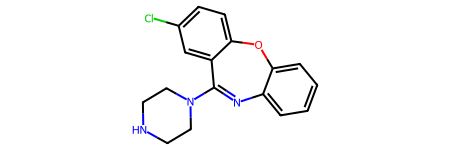

In [ ]:
print(f"SMILES:\t{train.smiles_standarized[100]}\nLabel:\t{train.label[100]}")
molecule = molecule_from_smiles(train.iloc[100].smiles_standarized)
print("Molecule:")
molecule

In [ ]:
graph = graph_from_molecule(molecule)
print("Graph (including self-loops):")
print("\tatom features\t", graph[0].shape)
print("\tbond features\t", graph[1].shape)
print("\tpair indices\t", graph[2].shape)

Graph (including self-loops):
	atom features	 (22, 29)
	bond features	 (72, 7)
	pair indices	 (72, 2)


In [ ]:
def prepare_batch(x_batch, y_batch):
    """Merges (sub)graphs of batch into a single global (disconnected) graph
    """

    atom_features, bond_features, pair_indices = x_batch

    # Obtain number of atoms and bonds for each graph (molecule)
    num_atoms = atom_features.row_lengths()
    num_bonds = bond_features.row_lengths()

    # Obtain partition indices (molecule_indicator), which will be used to
    # gather (sub)graphs from global graph in model later on
    molecule_indices = tf.range(len(num_atoms))
    molecule_indicator = tf.repeat(molecule_indices, num_atoms)

    # Merge (sub)graphs into a global (disconnected) graph. Adding 'increment' to
    # 'pair_indices' (and merging ragged tensors) actualizes the global graph
    gather_indices = tf.repeat(molecule_indices[:-1], num_bonds[1:])
    increment = tf.cumsum(num_atoms[:-1])
    increment = tf.pad(tf.gather(increment, gather_indices), [(num_bonds[0], 0)])
    pair_indices = pair_indices.merge_dims(outer_axis=0, inner_axis=1).to_tensor()
    pair_indices = pair_indices + increment[:, tf.newaxis]
    atom_features = atom_features.merge_dims(outer_axis=0, inner_axis=1).to_tensor()
    bond_features = bond_features.merge_dims(outer_axis=0, inner_axis=1).to_tensor()

    return (atom_features, bond_features, pair_indices, molecule_indicator), y_batch


def MPNNDataset(X, y, batch_size=32, shuffle=False):
    dataset = tf.data.Dataset.from_tensor_slices((X, (y)))
    if shuffle:
        dataset = dataset.shuffle(1024)
    return dataset.batch(batch_size).map(prepare_batch, -1).prefetch(-1)

In [ ]:
class EdgeNetwork(layers.Layer):
    def build(self, input_shape):
        self.atom_dim = input_shape[0][-1]
        self.bond_dim = input_shape[1][-1]
        self.kernel = self.add_weight(
            shape=(self.bond_dim, self.atom_dim * self.atom_dim),
            initializer="glorot_uniform",
            name="kernel",
        )
        self.bias = self.add_weight(
            shape=(self.atom_dim * self.atom_dim), initializer="zeros", name="bias",
        )
        self.built = True

    def call(self, inputs):
        atom_features, bond_features, pair_indices = inputs

        # Apply linear transformation to bond features
        bond_features = tf.matmul(bond_features, self.kernel) + self.bias

        # Reshape for neighborhood aggregation later
        bond_features = tf.reshape(bond_features, (-1, self.atom_dim, self.atom_dim))

        # Obtain atom features of neighbors
        atom_features_neighbors = tf.gather(atom_features, pair_indices[:, 1])
        atom_features_neighbors = tf.expand_dims(atom_features_neighbors, axis=-1)

        # Apply neighborhood aggregation
        transformed_features = tf.matmul(bond_features, atom_features_neighbors)
        transformed_features = tf.squeeze(transformed_features, axis=-1)
        aggregated_features = tf.math.unsorted_segment_sum(
            transformed_features,
            pair_indices[:, 0],
            num_segments=tf.shape(atom_features)[0],
        )
        return aggregated_features


class MessagePassing(layers.Layer):
    def __init__(self, units, steps=4, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.steps = steps

    def build(self, input_shape):
        self.atom_dim = input_shape[0][-1]
        self.message_step = EdgeNetwork()
        self.pad_length = max(0, self.units - self.atom_dim)
        self.update_step = layers.GRUCell(self.atom_dim + self.pad_length)
        self.built = True

    def call(self, inputs):
        atom_features, bond_features, pair_indices = inputs

        # Pad atom features if number of desired units exceeds atom_features dim.
        # Alternatively, a dense layer could be used here.
        atom_features_updated = tf.pad(atom_features, [(0, 0), (0, self.pad_length)])

        # Perform a number of steps of message passing
        for i in range(self.steps):
            # Aggregate information from neighbors
            atom_features_aggregated = self.message_step(
                [atom_features_updated, bond_features, pair_indices]
            )

            # Update node state via a step of GRU
            atom_features_updated, _ = self.update_step(
                atom_features_aggregated, atom_features_updated
            )
        return atom_features_updated

In [ ]:
class PartitionPadding(layers.Layer):
    def __init__(self, batch_size, **kwargs):
        super().__init__(**kwargs)
        self.batch_size = batch_size

    def call(self, inputs):

        atom_features, molecule_indicator = inputs

        # Obtain subgraphs
        atom_features_partitioned = tf.dynamic_partition(
            atom_features, molecule_indicator, self.batch_size
        )

        # Pad and stack subgraphs
        num_atoms = [tf.shape(f)[0] for f in atom_features_partitioned]
        max_num_atoms = tf.reduce_max(num_atoms)
        atom_features_stacked = tf.stack(
            [
                tf.pad(f, [(0, max_num_atoms - n), (0, 0)])
                for f, n in zip(atom_features_partitioned, num_atoms)
            ],
            axis=0,
        )

        # Remove empty subgraphs (usually for last batch in dataset)
        gather_indices = tf.where(tf.reduce_sum(atom_features_stacked, (1, 2)) != 0)
        gather_indices = tf.squeeze(gather_indices, axis=-1)
        return tf.gather(atom_features_stacked, gather_indices, axis=0)


class TransformerEncoderReadout(layers.Layer):
    def __init__(
        self, num_heads=8, embed_dim=64, dense_dim=512, batch_size=32, **kwargs
    ):
        super().__init__(**kwargs)

        self.partition_padding = PartitionPadding(batch_size)
        self.attention = layers.MultiHeadAttention(num_heads, embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.average_pooling = layers.GlobalAveragePooling1D()

    def call(self, inputs):
        x = self.partition_padding(inputs)
        padding_mask = tf.reduce_any(tf.not_equal(x, 0.0), axis=-1)
        padding_mask = padding_mask[:, tf.newaxis, tf.newaxis, :]
        attention_output = self.attention(x, x, attention_mask=padding_mask)
        proj_input = self.layernorm_1(x + attention_output)
        proj_output = self.layernorm_2(proj_input + self.dense_proj(proj_input))
        return self.average_pooling(proj_output)

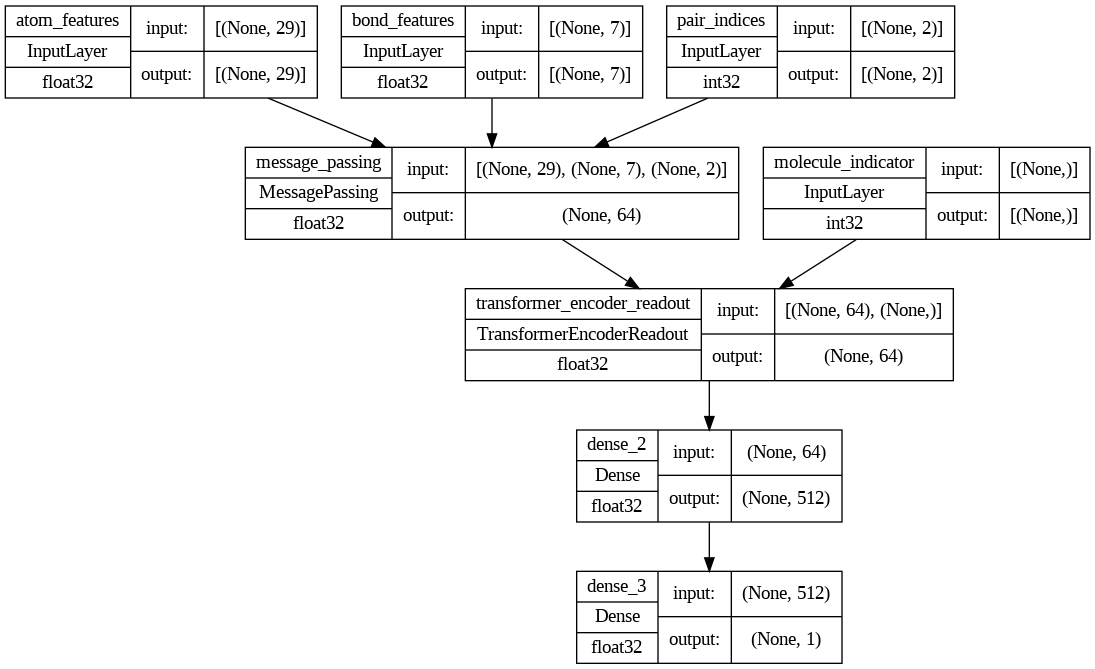

In [ ]:
def MPNNModel(
    atom_dim,
    bond_dim,
    batch_size=32,
    message_units=64,
    message_steps=4,
    num_attention_heads=8,
    dense_units=512,
):

    atom_features = layers.Input((atom_dim), dtype="float32", name="atom_features")
    bond_features = layers.Input((bond_dim), dtype="float32", name="bond_features")
    pair_indices = layers.Input((2), dtype="int32", name="pair_indices")
    molecule_indicator = layers.Input((), dtype="int32", name="molecule_indicator")

    x = MessagePassing(message_units, message_steps)(
        [atom_features, bond_features, pair_indices]
    )

    x = TransformerEncoderReadout(
        num_attention_heads, message_units, dense_units, batch_size
    )([x, molecule_indicator])

    x = layers.Dense(dense_units, activation="relu")(x)
    x = layers.Dense(1, activation=None)(x)

    model = keras.Model(
        inputs=[atom_features, bond_features, pair_indices, molecule_indicator],
        outputs=[x],
    )
    return model


mpnn = MPNNModel(
    atom_dim=x_train[0][0][0].shape[0], bond_dim=x_train[1][0][0].shape[0],
)

mpnn.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=5e-4),
    metrics=[keras.metrics.MeanAbsoluteError(name="MAE")],
)

keras.utils.plot_model(mpnn, show_dtype=True, show_shapes=True)

Epoch 1/40
4/4 - 17s - loss: 3.7086 - MAE: 1.5506 - val_loss: 1.4840 - val_MAE: 1.0473 - 17s/epoch - 4s/step
Epoch 2/40
4/4 - 2s - loss: 1.2495 - MAE: 0.9571 - val_loss: 1.2598 - val_MAE: 0.9469 - 2s/epoch - 377ms/step
Epoch 3/40
4/4 - 4s - loss: 1.1936 - MAE: 0.9214 - val_loss: 1.3406 - val_MAE: 0.9817 - 4s/epoch - 1s/step
Epoch 4/40
4/4 - 1s - loss: 1.1173 - MAE: 0.8869 - val_loss: 1.1893 - val_MAE: 0.8655 - 1s/epoch - 327ms/step
Epoch 5/40
4/4 - 1s - loss: 1.0376 - MAE: 0.8562 - val_loss: 1.0683 - val_MAE: 0.7821 - 1s/epoch - 360ms/step
Epoch 6/40
4/4 - 1s - loss: 0.9356 - MAE: 0.7914 - val_loss: 0.8543 - val_MAE: 0.7084 - 1s/epoch - 346ms/step
Epoch 7/40
4/4 - 2s - loss: 0.9081 - MAE: 0.7525 - val_loss: 0.6638 - val_MAE: 0.6386 - 2s/epoch - 387ms/step
Epoch 8/40
4/4 - 1s - loss: 0.9336 - MAE: 0.7826 - val_loss: 0.5959 - val_MAE: 0.6043 - 1s/epoch - 337ms/step
Epoch 9/40
4/4 - 2s - loss: 0.9153 - MAE: 0.7879 - val_loss: 0.6654 - val_MAE: 0.6240 - 2s/epoch - 504ms/step
Epoch 10/40
4/

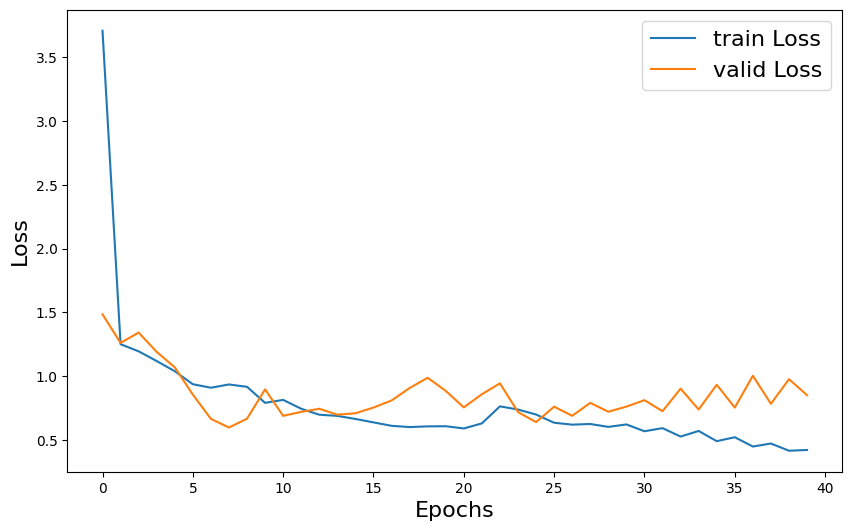

In [ ]:
train_dataset = MPNNDataset(x_train, y_train)
valid_dataset = MPNNDataset(x_valid, y_valid)
test_dataset = MPNNDataset(x_test, y_test)

history = mpnn.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=40,
    verbose=2,
)

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history["loss"], label="train Loss")
plt.plot(history.history["val_loss"], label="valid Loss")
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.legend(fontsize=16)

1/1 [==============================] - 2s 2s/step


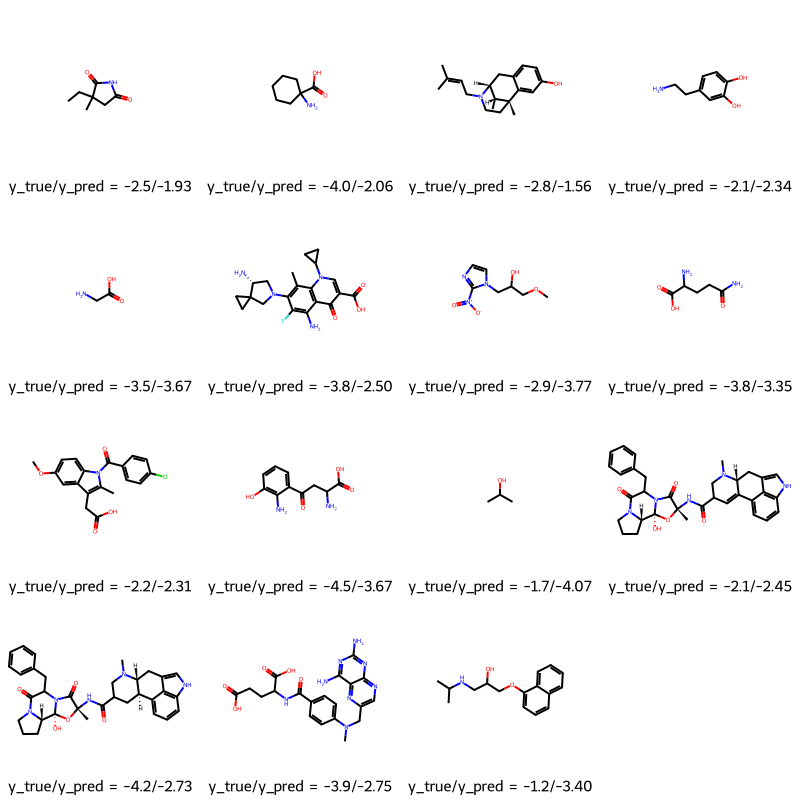

In [ ]:
molecules = [molecule_from_smiles(test.smiles_standarized.values[index]) for index in range(15)]
y_true = [test.label.values[index] for index in range(15)]
y_pred = tf.squeeze(mpnn.predict(test_dataset), axis=1)

legends = [f"y_true/y_pred = {y_true[i]}/{y_pred[i]:.2f}" for i in range(len(y_true))]
MolsToGridImage(molecules, molsPerRow=4, legends=legends)

In [ ]:
test

,smiles_standarized,label,group
0,CCC1(C)CC(=O)NC1=O,-2.5,test
1,NC1(C(=O)O)CCCCC1,-4.0,test
2,CC(C)=CCN1CC[C@@]2(C)c3cc(O)ccc3C[C@@H]1[C@H]2C,-2.8,test
3,NCCc1ccc(O)c(O)c1,-2.1,test
4,NCC(=O)O,-3.5,test
5,Cc1c(N2C[C@@H](N)C3(CC3)C2)c(F)c(N)c2c(=O)c(C(...,-3.8,test
6,COCC(O)Cn1ccnc1[N+](=O)[O-],-2.9,test
7,NC(=O)CCC(N)C(=O)O,-3.8,test
8,COc1ccc2c(c1)c(CC(=O)O)c(C)n2C(=O)c1ccc(Cl)cc1,-2.2,test
9,Nc1c(O)cccc1C(=O)CC(N)C(=O)O,-4.5,test


1/1 [==============================] - 0s 178ms/step


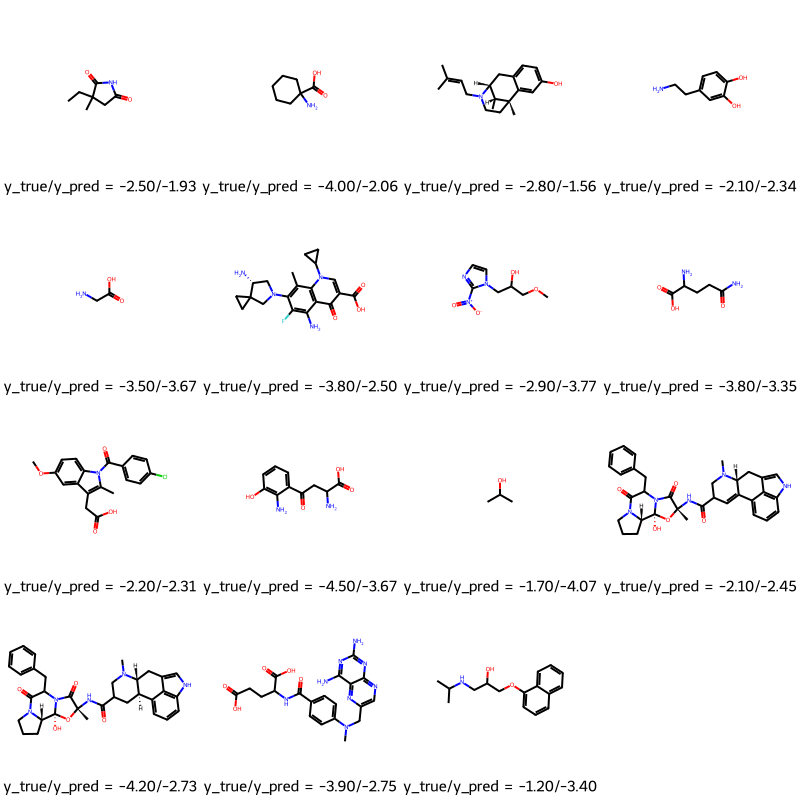

In [ ]:
# Assuming you have a function to generate molecules from SMILES strings
molecules = [molecule_from_smiles(test.smiles_standarized.values[index]) for index in range(15)]

# Fetch true numerical values (y_true) from your dataset
y_true = [test.label.values[index] for index in range(15)]

# Predict numerical values (y_pred) using the MPNN model
y_pred = mpnn.predict(test_dataset)

# Convert y_pred to 1D array (squeeze the output if necessary)
y_pred = np.squeeze(y_pred, axis=1)

# Prepare legends for visualization
legends = [f"y_true/y_pred = {y_true[i]:.2f}/{y_pred[i]:.2f}" for i in range(len(y_true))]

# Visualize molecules with legends showing true and predicted values
MolsToGridImage(molecules, molsPerRow=4, legends=legends)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
train_dataset = MPNNDataset(x_train, y_train)
valid_dataset = MPNNDataset(x_valid, y_valid)
test_dataset = MPNNDataset(x_test, y_test)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = mpnn.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=40,
    verbose=2,
    callbacks=[early_stopping]
)


Epoch 1/40
4/4 - 2s - loss: 0.3816 - MAE: 0.4667 - val_loss: 0.9466 - val_MAE: 0.7594 - 2s/epoch - 395ms/step
Epoch 2/40
4/4 - 1s - loss: 0.3781 - MAE: 0.4608 - val_loss: 0.9050 - val_MAE: 0.7517 - 1s/epoch - 371ms/step
Epoch 3/40
4/4 - 1s - loss: 0.3602 - MAE: 0.4460 - val_loss: 0.9442 - val_MAE: 0.7624 - 1s/epoch - 355ms/step
Epoch 4/40
4/4 - 1s - loss: 0.3454 - MAE: 0.4381 - val_loss: 0.9403 - val_MAE: 0.7531 - 1s/epoch - 363ms/step
Epoch 5/40
4/4 - 1s - loss: 0.3473 - MAE: 0.4368 - val_loss: 0.9053 - val_MAE: 0.7617 - 1s/epoch - 374ms/step
Epoch 6/40
4/4 - 2s - loss: 0.3181 - MAE: 0.4201 - val_loss: 0.9339 - val_MAE: 0.7605 - 2s/epoch - 442ms/step
Epoch 7/40
4/4 - 2s - loss: 0.3228 - MAE: 0.4234 - val_loss: 0.8655 - val_MAE: 0.7507 - 2s/epoch - 559ms/step
Epoch 8/40
4/4 - 2s - loss: 0.2922 - MAE: 0.3935 - val_loss: 0.9181 - val_MAE: 0.7604 - 2s/epoch - 506ms/step
Epoch 9/40
4/4 - 1s - loss: 0.2944 - MAE: 0.4035 - val_loss: 0.8568 - val_MAE: 0.7537 - 1s/epoch - 359ms/step
Epoch 10/4

1/1 [==============================] - 0s 240ms/step


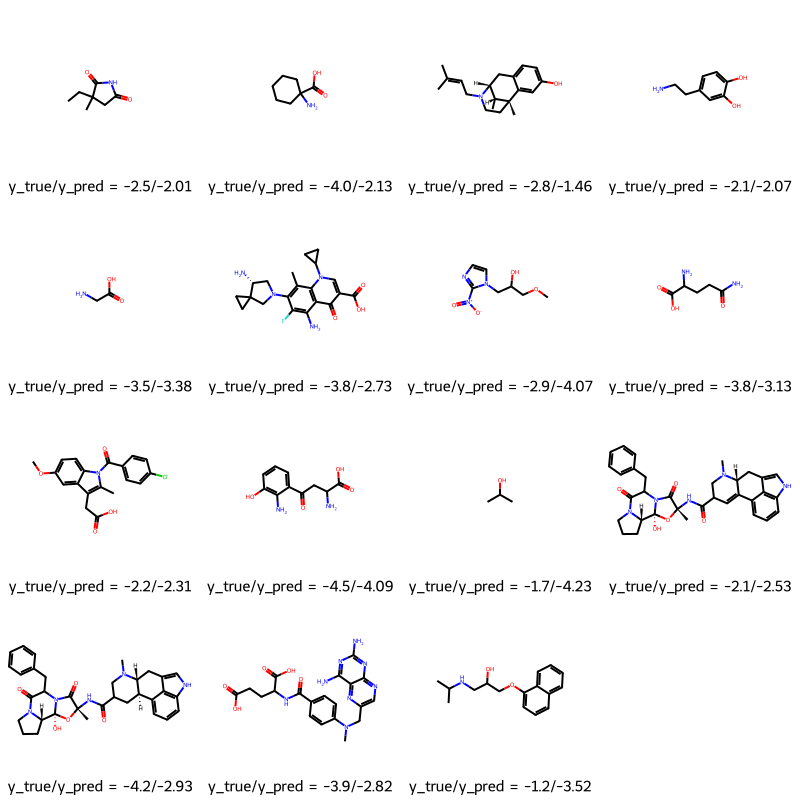

In [ ]:
molecules = [molecule_from_smiles(test.smiles_standarized.values[index]) for index in range(15)]
y_true = [test.label.values[index] for index in range(15)]
y_pred = tf.squeeze(mpnn.predict(test_dataset), axis=1)

legends = [f"y_true/y_pred = {y_true[i]}/{y_pred[i]:.2f}" for i in range(len(y_true))]
MolsToGridImage(molecules, molsPerRow=4, legends=legends)

1/1 [==============================] - 0s 143ms/step


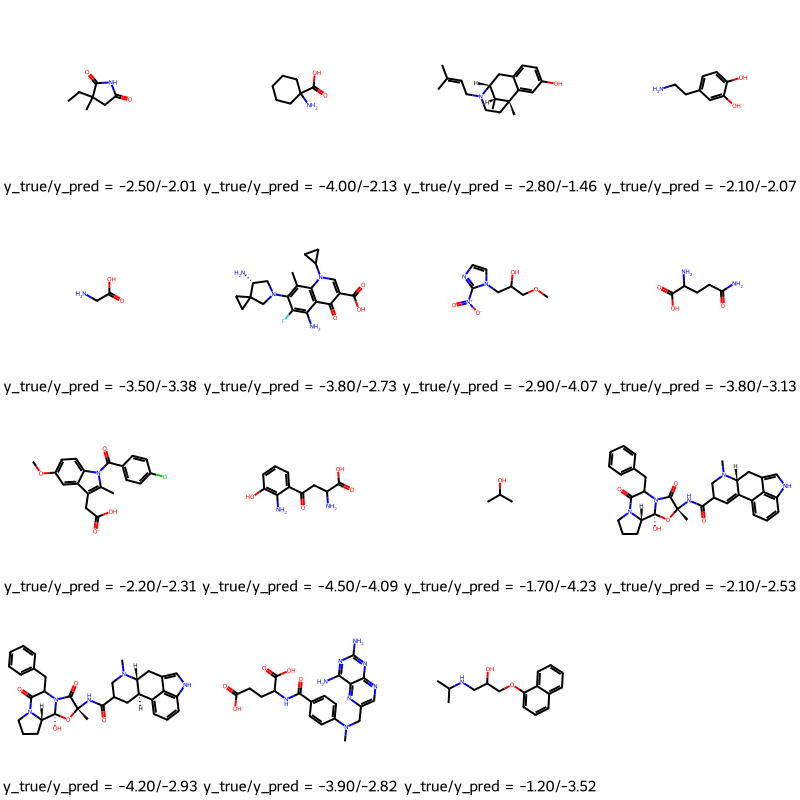

In [ ]:
# Assuming you have a function to generate molecules from SMILES strings
molecules = [molecule_from_smiles(test.smiles_standarized.values[index]) for index in range(15)]

# Fetch true numerical values (y_true) from your dataset
y_true = [test.label.values[index] for index in range(15)]

# Predict numerical values (y_pred) using the MPNN model
y_pred = mpnn.predict(test_dataset)

# Convert y_pred to 1D array (squeeze the output if necessary)
y_pred = np.squeeze(y_pred, axis=1)

# Prepare legends for visualization
legends = [f"y_true/y_pred = {y_true[i]:.2f}/{y_pred[i]:.2f}" for i in range(len(y_true))]

# Visualize molecules with legends showing true and predicted values
MolsToGridImage(molecules, molsPerRow=4, legends=legends)


In [ ]:
#mae and r^2

In [ ]:
test_dataset = MPNNDataset(x_test, y_test)

test_loss, test_mae = mpnn.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

y_pred = mpnn.predict(test_dataset)



1/1 [==============================] - 0s 273ms/step - loss: 1.5632 - MAE: 0.9940
Test Loss: 1.5631872415542603
Test MAE: 0.9939704537391663
1/1 [==============================] - 0s 239ms/step


1/1 [==============================] - 0s 366ms/step
Shape of y_test: (15,)
Shape of y_pred: (15,)
Mean Absolute Error (MAE): 0.9939704259236654
Mean Squared Error (MSE): 1.5631873214952423


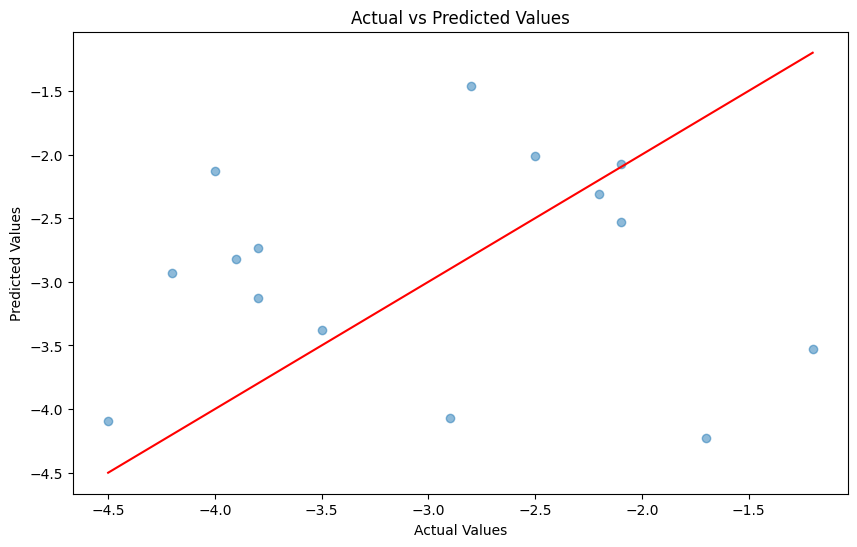

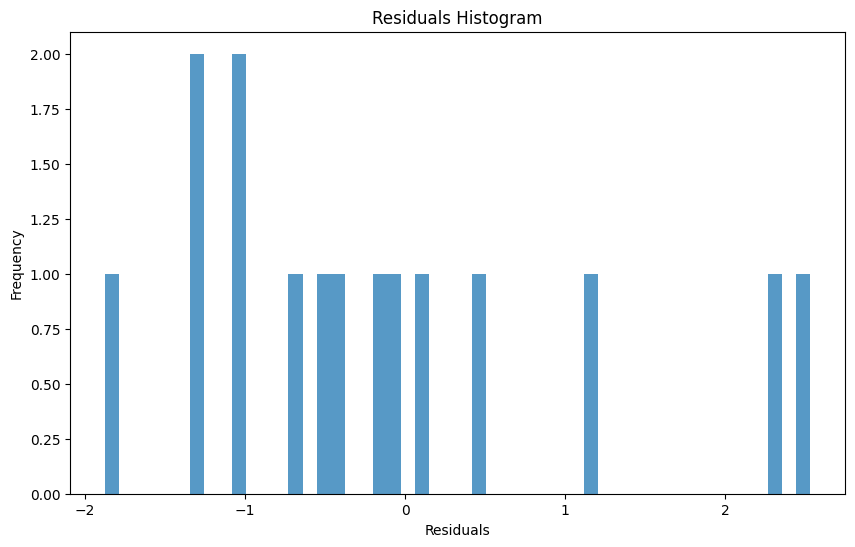

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Load the test dataset and make predictions
test_dataset = MPNNDataset(x_test, y_test)
y_pred = mpnn.predict(test_dataset)

# Ensure y_test and y_pred are numpy arrays
y_test = np.array(y_test)
y_pred = np.array(y_pred).squeeze()  # Remove the extra dimension if it exists

# Check the shape of y_test and y_pred
print(f"Shape of y_test: {y_test.shape}")
print(f"Shape of y_pred: {y_pred.shape}")

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Line of perfect prediction
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

# Plot residuals (errors)
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, alpha=0.75)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Histogram')
plt.show()


In [3]:
from rdkit import Chem
help(Chem.MolFromSmiles)


Help on built-in function MolFromSmiles in module rdkit.Chem.rdmolfiles:

MolFromSmiles(...)
    MolFromSmiles( (object)SMILES, (SmilesParserParams)params) -> Mol :
        Construct a molecule from a SMILES string.
        
             ARGUMENTS:
           
               - SMILES: the smiles string
           
               - params: used to provide optional parameters for the SMILES parsing
           
             RETURNS:
           
               a Mol object, None on failure.
           
        
    
        C++ signature :
            RDKit::ROMol* MolFromSmiles(boost::python::api::object,RDKit::SmilesParserParams)
    
    MolFromSmiles( (object)SMILES [, (bool)sanitize=True [, (dict)replacements={}]]) -> Mol :
        Construct a molecule from a SMILES string.
        
          ARGUMENTS:
        
            - SMILES: the smiles string
        
            - sanitize: (optional) toggles sanitization of the molecule.
              Defaults to True.
        
            